In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.nonlinearities import Logit


####GISAXS

import random
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from glob import glob

from dataset.ba_dataset import setup_data_loaders
from dataset.preprocessing import Transform

/home/zhdano82/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
%run train_surrogate.py --model 'fcnet' --minmax 1 --log 1 --in_shape 128 16 --n_samples 5000 --n_layers 3 --batch_size 64 --train 0 --n_channels 32 --n_epochs 10 --data_path '/bigdata/hplsim/aipp/Maksim/BA_simulation/layer_3/'

100%|██████████| 250/250 [00:08<00:00, 30.54it/s]

Data loaders created


In [20]:
model.load_state_dict(torch.load('./saved_models/fcnet___1_1_0_l1_3_128_16'))

<All keys matched successfully>

In [21]:
xs, ys = next(iter(loaders['train']))
x_pred = model(ys.cuda()).squeeze().cpu().detach()

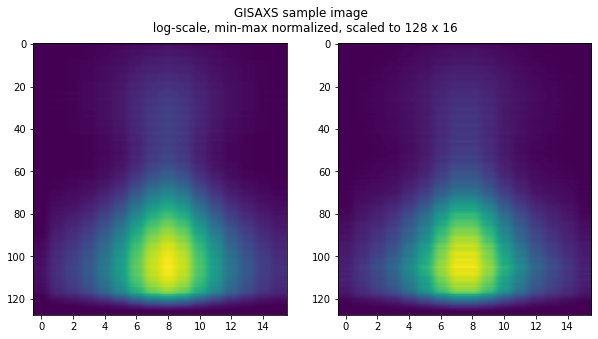

In [22]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(xs[0], aspect = 'auto', vmin = 0, vmax = 1)
ax[1].imshow(x_pred[0], aspect = 'auto', vmin = 0, vmax = 1)
plt.suptitle('GISAXS sample image \n log-scale, min-max normalized, scaled to 128 x 16')
plt.show()

In [23]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Taken from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html#Building-the-autoencoder
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=5, padding=2, stride=(4,1)), # 128x16 => 32x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=(2,1)),  # 32x16 => 32x16
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


In [24]:
from nflows.distributions.base import Distribution
from nflows.utils import torchutils
from torch.distributions import Uniform


class Uniform(Distribution):
    """A multivariate Normal with zero mean and unit covariance."""

    def __init__(self, shape):
        super().__init__()
        self._shape = torch.Size(shape)

    def _log_prob(self, inputs, context):
        # Note: the context is ignored.
        if inputs.shape[1:] != self._shape:
            raise ValueError(
                "Expected input of shape {}, got {}".format(
                    self._shape, inputs.shape[1:]
                )
            )
        return torch.distributions.Uniform(0,1).log_prob(inputs).sum(-1).cuda()

    def _sample(self, num_samples, context):
        if context is None:
            return torch.randn(num_samples, *self._shape, device=self._log_z.device)
        else:
            # The value of the context is ignored, only its size and device are taken into account.
            context_size = context.shape[0]
            samples = torch.rand(context_size * num_samples, *self._shape,
                                  device=context.device)
            return torchutils.split_leading_dim(samples, [context_size, num_samples])

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from nflows.transforms import splines
from nflows.transforms.base import (
    CompositeTransform,
    InputOutsideDomain,
    InverseTransform,
    Transform,
)
from nflows.utils import torchutils        
        
class Sigmoid(Transform):
    def __init__(self, temperature=1, eps=1e-6, learn_temperature=False):
        super().__init__()
        self.eps = eps
        if learn_temperature:
            self.temperature = nn.Parameter(torch.Tensor([temperature]))
        else:
            self.temperature = torch.Tensor([temperature])
            
        self.temperature = self.temperature.cuda()

    def forward(self, inputs, context=None):
        inputs = self.temperature * inputs
        outputs = torch.sigmoid(inputs)
        logabsdet = torchutils.sum_except_batch(
            torch.log(self.temperature) - F.softplus(-inputs) - F.softplus(inputs)
        )
        return outputs, logabsdet

    def inverse(self, inputs, context=None):

        inputs = torch.clamp(inputs, self.eps, 1 - self.eps)

        outputs = (1 / self.temperature) * (torch.log(inputs) - torch.log1p(-inputs))
        logabsdet = -torchutils.sum_except_batch(
            torch.log(self.temperature)
            - F.softplus(-self.temperature * outputs)
            - F.softplus(self.temperature * outputs)
        )
        return outputs, logabsdet
    
class Logit(InverseTransform):
    def __init__(self, temperature=1, eps=1e-6):
        super().__init__(Sigmoid(temperature=temperature, eps=eps))

In [25]:
num_layers = 5
base_dist = StandardNormal(shape=[18])

transforms = []
transforms.append(Logit())  
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=18))
    transforms.append(MaskedAffineAutoregressiveTransform(features=18, 
                                                          hidden_features=4,
                                                          context_features=16))
    
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).cuda()
enc = Encoder(1, 16, 16).cuda()
optimizer = optim.Adam(list(flow.parameters()) + list(enc.parameters()))


In [26]:
def surr_loss(x_exp, x_enc, surrmod, flow, n_samples, eps):
    y_sampled = flow.sample(n_samples, x_enc)
    x_exp = x_exp.unsqueeze(1).repeat(1,n_samples,1,1).reshape(-1,n_samples,2048)
    x_sm = surrmod(y_sampled.reshape(-1,18)).reshape(-1,n_samples,2048)
    return torch.clip(((x_exp - x_sm)**2).mean((1,2)) - eps, 0)

In [27]:
for x,y in loaders['train']:
    x = x.cuda()
    y = y.cuda()
    optimizer.zero_grad()
    x_enc = enc(x.unsqueeze(1))

In [28]:
num_epochs = 100
n_samples = 100
eps = 1e-3

epoch = 0

In [29]:
for _ in range(num_epochs):
    all_loss_nf = []
    all_loss_sm = []
    epoch += 1
    for x,y in loaders['train']:
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        x_enc = enc(x.unsqueeze(1))
        loss_nf = -flow.log_prob(inputs=y, context=x_enc)
        alpha = 0. if epoch < 10 else 1.
        loss_sm = alpha*surr_loss(x, x_enc, model, flow, n_samples, eps)
        loss = (loss_nf + loss_sm).mean()
        loss.backward()
        optimizer.step()
        all_loss_nf.append(loss_nf.mean().item())
        all_loss_sm.append(loss_sm.mean().item())
    print('Epoch: {}, NF Loss: {:.2f}, SM Loss: {:.3f}'.format(epoch, 
                                                               np.mean(all_loss_nf), 
                                                               np.mean(all_loss_sm)
                                                              ))    

Epoch: 1, NF Loss: 11.26, SM Loss: 0.000
Epoch: 2, NF Loss: 1.30, SM Loss: 0.000
Epoch: 3, NF Loss: -0.55, SM Loss: 0.000
Epoch: 4, NF Loss: -0.66, SM Loss: 0.000
Epoch: 5, NF Loss: -0.71, SM Loss: 0.000
Epoch: 6, NF Loss: -0.78, SM Loss: 0.000
Epoch: 7, NF Loss: -0.80, SM Loss: 0.000
Epoch: 8, NF Loss: -0.85, SM Loss: 0.000
Epoch: 9, NF Loss: -0.87, SM Loss: 0.000
Epoch: 10, NF Loss: -0.92, SM Loss: 0.035
Epoch: 11, NF Loss: -0.95, SM Loss: 0.035
Epoch: 12, NF Loss: -1.02, SM Loss: 0.035
Epoch: 13, NF Loss: -1.08, SM Loss: 0.034
Epoch: 14, NF Loss: -1.11, SM Loss: 0.034
Epoch: 15, NF Loss: -1.15, SM Loss: 0.034
Epoch: 16, NF Loss: -1.19, SM Loss: 0.034
Epoch: 17, NF Loss: -1.23, SM Loss: 0.034
Epoch: 18, NF Loss: -1.28, SM Loss: 0.034
Epoch: 19, NF Loss: -1.36, SM Loss: 0.034
Epoch: 20, NF Loss: -1.42, SM Loss: 0.033
Epoch: 21, NF Loss: -1.50, SM Loss: 0.033
Epoch: 22, NF Loss: -1.61, SM Loss: 0.033
Epoch: 23, NF Loss: -1.76, SM Loss: 0.033
Epoch: 24, NF Loss: -1.95, SM Loss: 0.032
Ep

KeyboardInterrupt: 

(-1.0, 1.0)

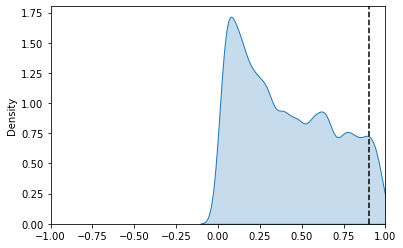

In [32]:
i = 0
par = 1
n = 1000

x_enc = x_enc[i,:].unsqueeze(0)
y_sampled = flow.sample(n, x_enc).squeeze().cpu().detach()

sns.kdeplot(np.array(y_sampled)[:,par], fill=True, bw_adjust=0.5);
plt.axvline(x=y[i,par].item(), color='k', linestyle='--', label = 'true value')
plt.xlim(-1,1)

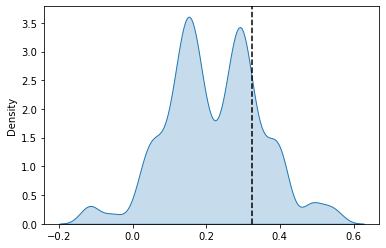

In [55]:
sns.kdeplot(np.array(y_sampled)[:,par], fill=True, bw_adjust=0.5);
plt.axvline(x=y[i,par].item(), color='k', linestyle='--', label = 'true value')

(array([ 2.,  1., 10., 16., 22., 13., 20., 12.,  1.,  3.]),
 array([-0.12119887, -0.05402707,  0.01314473,  0.08031652,  0.14748833,
         0.21466012,  0.28183192,  0.3490037 ,  0.4161755 ,  0.4833473 ,
         0.5505191 ], dtype=float32),
 <BarContainer object of 10 artists>)

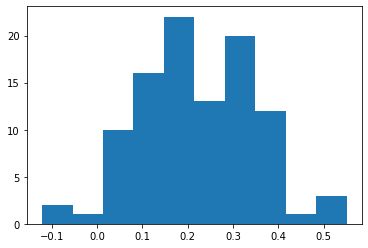

In [45]:
plt.hist(np.array(y_sampled)[:,0])